In [1]:
%%time
%matplotlib inline
%load_ext autoreload
%autoreload 2

import json
import sys
import time
from dataclasses import dataclass
from pathlib import Path

import pandas as pd
from dotenv import load_dotenv
from openai import OpenAI
from tqdm import tqdm


@dataclass
class Config:
    project_dir: Path = Path("../../")
    model_dir: Path = project_dir / "models"
    outputs_dir: Path = project_dir / "outputs"
    data_dir: Path = project_dir / "data"
    raw_dir: Path = data_dir / "raw"
    interim_dir: Path = data_dir / "interim"
    processed_dir: Path = data_dir / "processed"


config = Config()
sys.path.append(str(config.project_dir.resolve()))
load_dotenv()

CPU times: user 2.22 s, sys: 699 ms, total: 2.91 s
Wall time: 4.42 s


True

In [2]:
df_reviews = pd.read_csv(
    config.interim_dir / "olist_order_reviews_translated_label_merged.csv",
)
df_reviews["review_creation_date"] = pd.to_datetime(df_reviews["review_creation_date"])
df_reviews["review_creation_month"] = df_reviews["review_creation_date"].dt.to_period(
    "M"
)
df_reviews["review_answer_timestamp"] = pd.to_datetime(
    df_reviews["review_answer_timestamp"]
)
df_reviews["review_answer_month"] = df_reviews["review_answer_timestamp"].dt.to_period(
    "M"
)
df_reviews["review_answer_date"] = df_reviews["review_answer_timestamp"].dt.to_period(
    "D"
)
df_orders = pd.read_csv(config.interim_dir / "olist_orders_customer_merged.csv")
df_item_products = pd.read_csv(
    config.interim_dir / "olist_item_product_seller_merged.csv"
)
df_orders_item_products_merged = pd.merge(
    df_orders, df_item_products, on="order_id", how="left"
)
assert (
    df_orders_item_products_merged["order_id"].nunique()
    == df_orders["order_id"].nunique()
)
df_orders_item_products_review_merged = pd.merge(
    df_orders_item_products_merged,
    df_reviews,
    on="order_id",
    how="left",
)
assert (
    df_orders_item_products_review_merged["order_id"].nunique()
    == df_orders_item_products_merged["order_id"].nunique()
)

In [4]:
df_review_no_null = (
    df_reviews.dropna(subset=["review_comment_message_en"])[
        [
            "review_id",
            "review_comment_message_en",
            "label_score",
            "label_translated",
            "modified_review_score",
            "meaningful_words",
        ]
    ]
    .drop_duplicates()
    .reset_index()
    .drop(columns=["index"])
)
df_reviews_unique = df_reviews[
    [
        "review_id",
        "review_comment_message_en",
        "label_score",
        "label_translated",
        "modified_review_score",
        "meaningful_words",
    ]
].drop_duplicates()
print(f"df_reviews_unique.shape: {df_reviews_unique.shape}")
print(f"df_review_no_null.shape: {df_review_no_null.shape}")


df_reviews_unique.shape: (98410, 6)
df_review_no_null.shape: (40650, 6)


## カテゴライズ

In [31]:
categorize_prompt = """
You are an expert in analyzing customer product reviews.

# Task
- Understand the content of the reviews accurately and categorize them.
- Return the categorization results in the specified JSON format.
- Create appropriate categories based on the review content.

# Response Format
You must return a JSON array of objects, where each object has:
- "id": the index number of the review (integer)
- "categories": an array of category strings

Example response format:
[
    {"id": 0, "categories": ["Delivery Issue"]},
    {"id": 1, "categories": ["Customer Service Issue"]}
]

# Categorization Rules
- Consider the context of the entire review and understand the actual feelings and intent of the customer.
- Keep the category names as few and precise as possible.
- Use concise, clear English category names.
- Multiple categories are basically not allowed.
- If the comment praises something, the categoy name must end with "praise".
- If the comment describes some issues, the categoy name must end with "issue".
- If the comment describes some experience, the categoy name must end with "experience".
- If categorization is difficult or the review lacks meaningful content, use ["Unclassifiable"].
- Create new categories as needed based on the review content, but maintain consistency in naming across similar issues.

# Examples
Input: [
    {"id": 0, "text": "I didn't receive the product, and the refund on the card was only made two months later."},
    {"id": 1, "text": "Thanks"},
    {"id": 2, "text": "The product is not exactly as advertised in the image, but the customer service was very helpful."}
]

Output: [
    {"id": 0, "categories": ["Delivery Issue"]},
    {"id": 1, "categories": ["Unclassifiable"]},
    {"id": 2, "categories": ["Product Mismatch Issue"]}
]
"""

In [38]:
def classify_review_sentiment(texts, batch_size=40):
    """
    レビューテキストの内容を分析し、主要な感想ポイントを分類する
    """
    client = OpenAI()
    classifications = []
    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i : i + batch_size]
        input_texts = [{"id": j, "text": text} for j, text in enumerate(batch)]
        try:
            response = client.chat.completions.create(
                model="gpt-4o-mini",
                messages=[
                    {
                        "role": "system",
                        "content": categorize_prompt,
                    },
                    {
                        "role": "user",
                        "content": f"Please classify the following reviews and return the result in the specified JSON format: {json.dumps(input_texts, ensure_ascii=False)}",
                    },
                ],
                temperature=0.2,
            )
            try:
                content = response.choices[0].message.content
                # マークダウンの記号を削除
                content = content.strip()
                if content.startswith("```"):
                    content = content.split("```")[1]
                if content.startswith("json"):
                    content = content.split("\n", 1)[1]
                content = content.strip()
                classified_batch = json.loads(content)
                if not isinstance(classified_batch, list):
                    raise ValueError("Response is not a list")
                for item in classified_batch:
                    if "id" not in item or "categories" not in item:
                        raise ValueError("Invalid response format")
                classified_batch = sorted(classified_batch, key=lambda x: x["id"])
                # カテゴリーリストをJSON文字列に変換
                classifications.extend(
                    [json.dumps(item["categories"]) for item in classified_batch]
                )
            except (json.JSONDecodeError, ValueError) as e:
                print(f"Error processing response: {e}")
                print(f"Raw response: {response.choices[0].message.content}")
                classifications.extend([json.dumps(["Unclassifiable"]) for _ in batch])
            time.sleep(1)
        except Exception as e:
            print(f"API call error: {e}")
            classifications.extend([json.dumps(["Unclassifiable"]) for _ in batch])

    return classifications


def process_review_classification(
    df, column_name="review_comment_message_en", max_rows=100
):
    """
    データフレームの英訳済みレビューを分類する
    """
    df = df.copy()
    non_null_mask = df[column_name].notna()
    texts_to_classify = df.loc[non_null_mask, column_name].head(max_rows).tolist()
    print(f"Starting classification for {len(texts_to_classify)} reviews")

    classifications = classify_review_sentiment(texts_to_classify)
    df["review_categories"] = None
    indices = df.loc[non_null_mask].head(max_rows).index
    df.loc[indices, "review_categories"] = classifications

    # カテゴリーを文字列からリストに戻す（必要な場合）
    df["review_categories"] = df["review_categories"].apply(
        lambda x: json.loads(x) if isinstance(x, str) else x
    )

    return df


# 実行例
df_reviews_unique_with_categories = process_review_classification(
    df_reviews_unique, max_rows=df_reviews_unique.shape[0]
)
df_reviews_unique_with_categories["review_categories_str"] = (
    df_reviews_unique_with_categories["review_categories"].apply(
        lambda x: "_".join(x) if isinstance(x, list) else None
    )
)

Starting classification for 40650 reviews


100%|██████████| 1017/1017 [4:40:42<00:00, 16.56s/it]     


In [81]:
df_reviews_with_categories = pd.merge(
    df_reviews,
    df_reviews_unique_with_categories[
        ["review_id", "review_categories", "review_categories_str"]
    ],
    on="review_id",
    how="left",
)
assert df_reviews_with_categories.shape[0] == df_reviews.shape[0]

In [85]:
df_reviews_with_categories.to_csv(
    config.interim_dir
    / "olist_order_reviews_translated_label_review_categories_merged.csv",
    index=False,
)


## カテゴライズの妥当性

In [86]:
df_reviews_with_categories_no_null = df_reviews_with_categories.dropna(
    subset=["review_comment_message_en"]
)

In [88]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = model.encode(
    df_reviews_with_categories_no_null["review_comment_message_en"].values.tolist()
)


/Users/shim-kojio/Desktop/ey_sat_lab/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


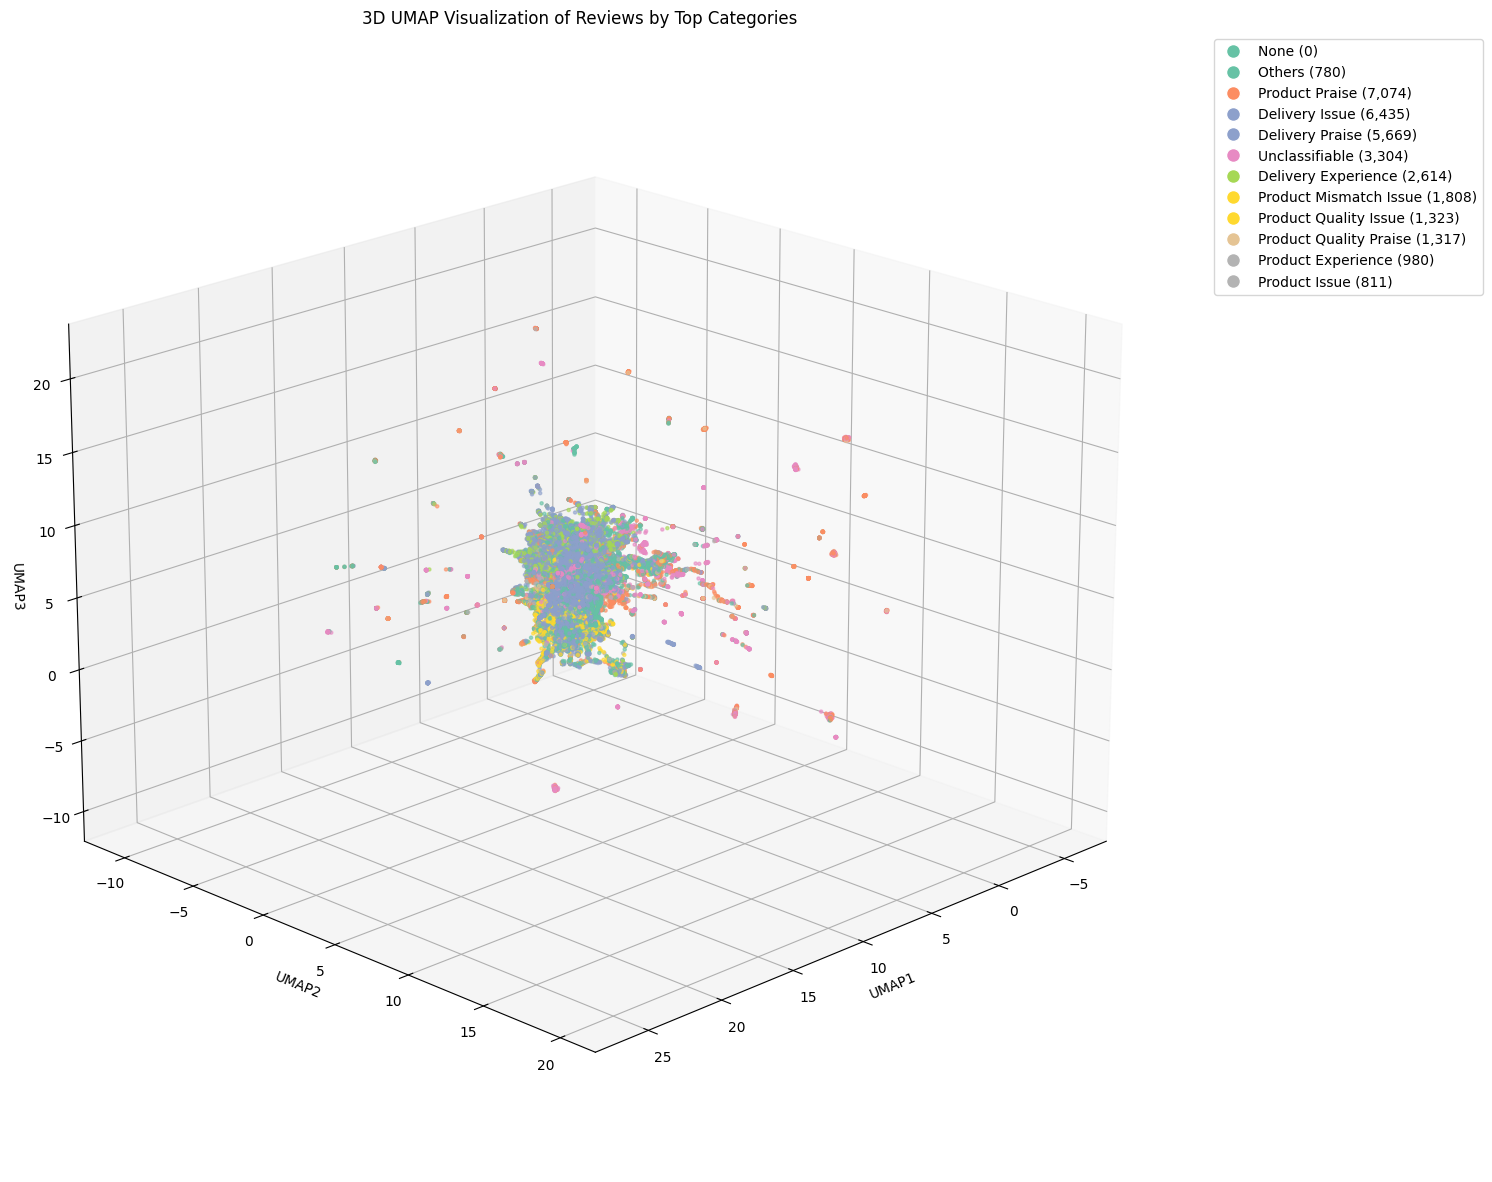


Category Counts:
None: 0
Others: 780
Product Praise: 7,074
Delivery Issue: 6,435
Delivery Praise: 5,669
Unclassifiable: 3,304
Delivery Experience: 2,614
Product Mismatch Issue: 1,808
Product Quality Issue: 1,323
Product Quality Praise: 1,317
Product Experience: 980
Product Issue: 811


In [107]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import umap

# UMAP で3次元に圧縮
reducer = umap.UMAP(n_components=3, n_neighbors=15, min_dist=0.2, metric="cosine")
umap_embeddings_3d = reducer.fit_transform(embeddings)

# カテゴリーの頻度を計算
category_counts = df_reviews_with_categories_no_null[
    "review_categories_str"
].value_counts()
top_2_categories = category_counts.head(10).index.tolist()


# カテゴリーを変換する関数（上位2つ以外は"Others"に）
def convert_to_top_categories(category):
    if pd.isna(category):
        return "None"
    elif category in top_2_categories:
        return category
    else:
        return "Others"


# カテゴリーを変換
categories_list = df_reviews_with_categories_no_null["review_categories_str"].tolist()
simplified_categories = [convert_to_top_categories(cat) for cat in categories_list]

# カラーマップを作成
unique_categories = ["None", "Others"] + top_2_categories
colors = plt.cm.Set2(np.linspace(0, 1, len(unique_categories)))
color_dict = dict(zip(unique_categories, colors))

# 各点の色を決定
point_colors = [color_dict[category] for category in simplified_categories]

# 3D散布図の作成
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection="3d")

scatter = ax.scatter(
    umap_embeddings_3d[:, 0],
    umap_embeddings_3d[:, 1],
    umap_embeddings_3d[:, 2],
    c=point_colors,
    s=5,
    alpha=0.6,
)

# 凡例を追加（カテゴリー名と出現回数を表示）
legend_elements = [
    plt.Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        markerfacecolor=color_dict[cat],
        label=f"{cat} ({category_counts.get(cat, sum(pd.isna(categories_list)) if cat == 'None' else sum(~category_counts.index.isin(top_2_categories)) if cat == 'Others' else category_counts[cat]):,})",
        markersize=10,
    )
    for cat in unique_categories
]

ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc="upper left")
ax.set_title("3D UMAP Visualization of Reviews by Top Categories")
ax.set_xlabel("UMAP1")
ax.set_ylabel("UMAP2")
ax.set_zlabel("UMAP3")

# グラフを見やすくするための視点調整
ax.view_init(elev=20, azim=45)

plt.tight_layout()
plt.show()

# 各カテゴリーの件数を表示
print("\nCategory Counts:")
for cat in unique_categories:
    if cat == "None":
        count = sum(pd.isna(categories_list))
    elif cat == "Others":
        count = sum(~category_counts.index.isin(top_2_categories))
    else:
        count = category_counts[cat]
    print(f"{cat}: {count:,}")